# FlowPic replication

For the course of this exploration I'll be attempting to replicate salient aspects of [FlowPic: Encrypted Internet Traffic Classification is as Easy as Image Recognition](https://ieeexplore.ieee.org/document/8845315) by Tal Shapira and Yuval Shavitt.

In [1]:
import sys
import os
parent_dir = os.path.dirname(os.getcwd())
sys.path.insert(0, parent_dir)
import src

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

import ipaddress
from ipaddress import ip_address as IP

import tensorflow as tf
from tensorflow import keras

## Preprocessing

### Dataset preparations

> We split each pcap file to unidirectional flows,  where  each  flow  is  defined  by  a  5-tuple  {source  IP,source port, destination IP, destination port, protocol}

This suggests the following process/changes to our preprocessing:
- Packet level unbinning should produce multiple dataframes
- Each dataframe needs to have a unique pair of IPs, *direction*, etc.
    - Since we're assuming a VPN is in use, we should be able to clean the data so that only the VPN traffic remains, then we can just split it on direction

In [2]:
raw_files = glob.glob('../data/raw/*youtube*-vpn*')
f = np.random.choice(raw_files)
# f = '../data/raw/stdoan-youtube[720p60]-1x-vpn-windows-clean-20201102.csv'
print(f)
df_raw = pd.read_csv(f)
df = src.data.clean(df_raw)
print(df.IP1.unique(), df.IP2.unique())
df

../data/raw/apristin-youtube[1440p60]-1x-vpn-windows-noisy-20201102-2.csv
['192.168.1.151'] ['137.110.0.70']


,Time,IP1,Port1,IP2,Port2,Proto,1->2Bytes,2->1Bytes,1->2Pkts,2->1Pkts,packet_times,packet_sizes,packet_dirs
0,1604342753,192.168.1.151,49802,137.110.0.70,443,17,63521,1396855,490,1045,1604342753003;1604342753477;1604342753478;1604...,370;1366;423;126;1346;1346;1346;1346;1346;1346...,1;1;1;2;2;2;2;2;2;2;2;2;2;2;2;2;2;1;1;1;1;1;1;...
3,1604342755,192.168.1.151,49802,137.110.0.70,443,17,1525,1870,8,10,1604342755246;1604342755261;1604342755262;1604...,162;411;303;126;126;165;106;162;126;106;192;31...,1;1;1;2;2;2;2;2;1;1;2;2;2;2;1;1;1;2;
4,1604342756,192.168.1.151,49802,137.110.0.70,443,17,127,138,1,1,1604342756877;1604342756954;,127;138;,1;2;
5,1604342757,192.168.1.151,49802,137.110.0.70,443,17,53968,1166124,399,884,1604342757172;1604342757176;1604342757176;1604...,126;1366;423;157;126;126;126;126;126;1346;1346...,1;1;1;2;2;1;1;2;2;2;2;2;2;2;2;2;2;2;2;2;2;2;2;...
6,1604342758,192.168.1.151,49802,137.110.0.70,443,17,1039,1936,6,7,1604342758001;1604342758005;1604342758025;1604...,126;370;522;411;309;165;126;126;165;126;191;21...,1;1;2;2;2;2;1;1;1;2;2;2;1;
...,...,...,...,...,...,...,...,...,...,...,...,...,...
389,1604343049,192.168.1.151,49802,137.110.0.70,443,17,666,1000,4,6,1604343049249;1604343049273;1604343049273;1604...,249;126;165;218;200;165;126;126;165;126;,1;2;2;2;2;2;1;1;1;2;
391,1604343050,192.168.1.151,49802,137.110.0.70,443,17,164,106,1,1,1604343050657;1604343050743;,164;106;,1;2;
392,1604343051,192.168.1.151,49802,137.110.0.70,443,17,1396,946,4,6,1604343051150;1604343051180;1604343051180;1604...,979;126;165;207;157;165;126;126;165;126;,1;2;2;2;2;2;1;1;1;2;
395,1604343052,192.168.1.151,49802,137.110.0.70,443,17,127,138,1,1,1604343052858;1604343052886;,127;138;,1;2;


The cleaning isn't perfect. May need to revisit.

- Sometimes there are lots of 260x:x IPv6 communications, with many different addresses -- but they seem to be very important and contain the bulk of the packets. (See stdoan files)
- Sometimes there are communications where the VPN IP is in column 1 -- this should be addressed by splitting by direction... but also needs splitting by IP if we're going to split by direction...
- Sometimes there are *tons* of communications with "Shared Address Space" IPs -- again making there be *tons* of IPs that (I think) are truly contibuting to the same flow. (See arv020 files)
- Often there are non-vpn IPs that are still included

### Data Augmentation

> we  divide  each  unidirectional  flow  to  60  seconds  blocks

In [3]:
chunks = src.data.preprocess(
    df, chunk_length='60s',
    split_ips=False,
    split_directions=False
)
chunks[0]

Port1  Port2  Proto   packet_times  \
IP1           IP2          packet_dirs                                       
192.168.1.151 137.110.0.70 1            49802    443     17  1604342753003   
                           1            49802    443     17  1604342753477   
                           1            49802    443     17  1604342753478   
                           2            49802    443     17  1604342753511   
                           2            49802    443     17  1604342753511   
...                                       ...    ...    ...            ...   
                           1            49802    443     17  1604342812684   
                           2            49802    443     17  1604342812709   
                           1            49802    443     17  1604342812990   
                           1            49802    443     17  1604342812991   
                           1            49802    443     17  1604342813001   

                                        packet_sizes               timestamp  
IP1           IP2          packet_dirs                                        
192.168.1.151 137.110.0.70 1                     370 2020-11-02 18:45:53.003  
                           1                    1366 2020-11-02 18:45:53.477  
                           1                     423 2020-11-02 18:45:53.478  
                           2                     126 2020-11-02 18:45:53.511  
                           2                    1346 2020-11-02 18:45:53.511  
...                                              ...                     ...  
                           1                     127 2020-11-02 18:46:52.684  
                           2                     138 2020-11-02 18:46:52.709  
                           1                    1366 2020-11-02 18:46:52.990  
                           1                     423 2020-11-02 18:46:52.991  
                           1                     370 2020-11-02 18:46:53.001  

[20737 rows x 6 columns]

## FlowPic Construction

> {IP packet size, time of arrival}

> At the first stage, we plot all record  pairs by  defining  our  X-axis  as  the  packet  arrival time, and  Y-axis  as  the  packet  size.

> An  absolute  majority  of the  packet  sizes  do  not  cross  the  1500  bytes  (which  is  the Ethernet MTU value), thus we disregard all packets with size greater  than  1500  (less  than  5%  of  all  packets),  and  limit our  Y-axis to  be  between 1  to  1500.

> For  the  X-axis, first  we normalize  all  time  of  arrival  values  by  subtracting  the  time of  arrival  of  the  first  packet  in  the  flow.  For  simplicity,  we set the 2D-histogram to be a square image. For this purpose, we  normalized  all  time  of  arrival  values  to  be  between  0 to  1500  (namely,  60  seconds  is  mapped  to  1500).

In [4]:
h = src.features.flowpic(chunks[0])

(<Figure size 720x720 with 1 Axes>,
 <AxesSubplot:xlabel='Normalized arrival time', ylabel='Packet size (bytes)'>)

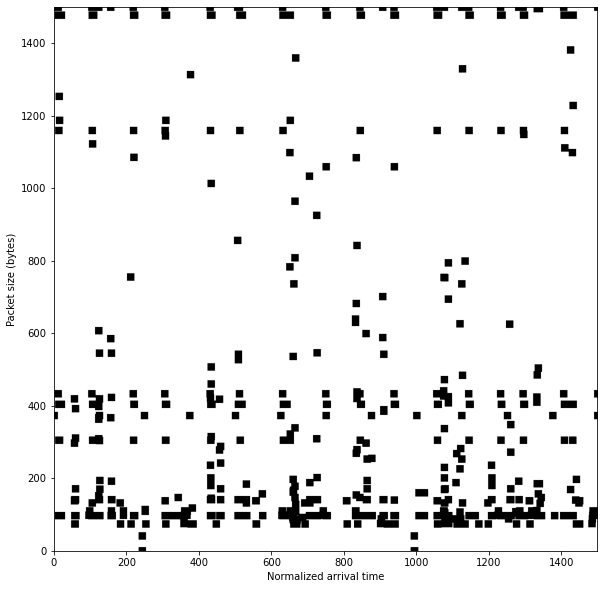

In [5]:
src.charts.flowpic(h, pixel_growth=10)

## All wrapped up

In [6]:
def random_flowpic(pattern='../data/raw/*-vpn-*', direction=None):
    """
    Direction {0: uploading, 1: downloading, None: both}
    """
    f = np.random.choice(glob.glob(pattern))
    df = pd.read_csv(f)
    clean = src.data.clean(df)
    if direction is not None:
        chunks = src.data.preprocess(clean, split_directions=True)[direction]
    else:
        chunks = src.data.preprocess(clean)

    hist = src.features.flowpic(chunks[-1])
    
    fig, ax = src.charts.flowpic(hist)
    
    fig.suptitle(f, fontsize=16)
    fig.tight_layout()
    
    return chunks, hist

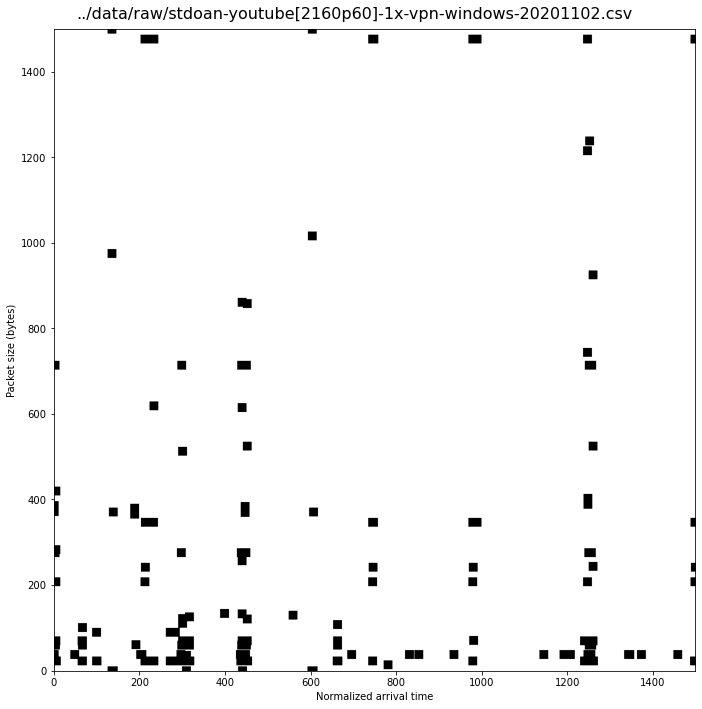

In [11]:
c, h = random_flowpic('../data/raw/stdoan*youtube*-vpn-*1102.csv', direction=1)

Very possible there are still just some un-clean data in our repository.

## Possible extension

We could add a color chanel to our data for direction. That way we don't need to get rid of a direction entirely, but can still include it as a feature.

---
# Old Code

In [8]:
def unbin_packets(df):
    """
    """
    
    df = df.drop(columns=[
        'Time', '1->2Bytes', '2->1Bytes', '1->2Pkts', '2->1Pkts'
    ])
    
    packet_cols = ['packet_times', 'packet_sizes', 'packet_dirs']
#     packetlist_cols = [s.rstrip('s') for s in packet_cols]
    
    # Convert the strings `val1;val2;` into lists `[val1, val2]`
    df[packet_cols] = (
        df.loc[:,packet_cols]
        .apply(lambda ser: ser.str.split(';').str[:-1])
    )
    
    # 'Explode' the lists so each element gets its own row.
    exploded = (
        df
        .apply(
            lambda ser: ser.explode().astype(int) if ser.name in packet_cols else ser
        )
    )
    
    return exploded

In [142]:
unbinned = unbin_packets(df)

Perhaps if a particular flow constitutes more than x% of the unbinned data then we should single it out?

In [143]:
from functools import reduce

def dominating_flow(df, threshold=0.9):
    
    ip1_props = df.IP1.value_counts(normalize=True)
    ip2_props = df.IP2.value_counts(normalize=True)
    
    masks = []
    
    if ip1_props[0] > threshold:
        masks.append(
            df.IP1 == ip1_props.index[0]
        )
        
    if ip2_props[0] > threshold:
        masks.append(
            df.IP2 == ip2_props.index[0]
        )
        
    if masks:
        return df[reduce(lambda x, y: y & x, masks, True)]
    else:
        return df

In [144]:
dom = dominating_flow(unbinned)
dom

,IP1,Port1,IP2,Port2,Proto,packet_times,packet_sizes,packet_dirs
0,10.0.0.236,50074,137.110.0.69,443,17,1605151149801,106,2
0,10.0.0.236,50074,137.110.0.69,443,17,1605151149804,151,2
0,10.0.0.236,50074,137.110.0.69,443,17,1605151149804,235,2
0,10.0.0.236,50074,137.110.0.69,443,17,1605151149805,106,1
0,10.0.0.236,50074,137.110.0.69,443,17,1605151149806,106,2
...,...,...,...,...,...,...,...,...
9279,10.0.0.236,50074,137.110.0.69,443,17,1605154731137,171,2
9279,10.0.0.236,50074,137.110.0.69,443,17,1605154731138,118,1
9279,10.0.0.236,50074,137.110.0.69,443,17,1605154731406,172,1
9279,10.0.0.236,50074,137.110.0.69,443,17,1605154731498,174,2


Let's split up by ip pairs and direction.

Afterwards, if our data had a bunch of IPs, we can chuck out dataframes that are too small or something like that.

In [145]:
keys = ['IP1', 'IP2', 'packet_dirs']

indexed = (
    dom
    .sort_values(keys)
    .set_index(keys)
)
indexed

Port1  Port2  Proto   packet_times  \
IP1        IP2          packet_dirs                                       
10.0.0.236 137.110.0.69 1            50074    443     17  1605151149805   
                        1            50074    443     17  1605151149809   
                        1            50074    443     17  1605151149817   
                        1            50074    443     17  1605151149818   
                        1            50074    443     17  1605151149818   
...                                    ...    ...    ...            ...   
                        2            50074    443     17  1605154730618   
                        2            50074    443     17  1605154730629   
                        2            50074    443     17  1605154730629   
                        2            50074    443     17  1605154731137   
                        2            50074    443     17  1605154731498   

                                     packet_sizes  
IP1        IP2          packet_dirs                
10.0.0.236 137.110.0.69 1                     106  
                        1                     106  
                        1                     106  
                        1                     146  
                        1                     146  
...                                           ...  
                        2                     138  
                        2                     495  
                        2                     191  
                        2                     171  
                        2                     174  

[61196 rows x 5 columns]

In [146]:
indexed.index.value_counts(normalize=True)

(10.0.0.236, 137.110.0.69, 2)    0.520737
(10.0.0.236, 137.110.0.69, 1)    0.479263
dtype: float64

Just looked at a file with tons of the 260x IPs... I don't know how to deal with those.

For the moment might just chuck out dataframes that don't boil down to two index levels.

In [147]:
assert max(indexed.index.levshape) == 2, f"Couldn't determine a single main flow from the data! {indexed.index.levshape}"

In [148]:
fidx = indexed.index.unique()

download_idx = np.argwhere(fidx.levels[2] == 2)[0][0]

down = indexed.loc[fidx[download_idx]]
up = indexed.loc[fidx[1-download_idx]]

In [149]:
def chunk(df, chunk_length='60s'):
    """
    Returns a list of DataFrames, each `chunk_length` long in duration.
    """
    
    df_time = df.assign(timestamp=pd.to_datetime(df.packet_times, unit='ms'))
    # Important that we specify `origin='start'`, otherwise specifying a minute
    # will create chunks at e.g. 5:01, 5:02, ..., when we want to just take
    # 60s from the very first observation
    resampled = df_time.resample(chunk_length, on='timestamp', origin='start')

    chunks = []
    for (timestamp, frame) in resampled:
        chunks.append(frame)

    # Get rid of last chunk if it's incomplete
    last = chunks[-1]
    if last.timestamp.max() - last.timestamp.min() < pd.Timedelta(chunk_length):
        chunks.pop()

    return chunks

In [150]:
chunks = chunk(down)
chunks[0]

Port1  Port2  Proto   packet_times  \
IP1        IP2          packet_dirs                                       
10.0.0.236 137.110.0.69 2            50074    443     17  1605151149801   
                        2            50074    443     17  1605151149804   
                        2            50074    443     17  1605151149804   
                        2            50074    443     17  1605151149806   
                        2            50074    443     17  1605151149809   
...                                    ...    ...    ...            ...   
                        2            50074    443     17  1605151209438   
                        2            36720    443      6  1605151209674   
                        2            36720    443      6  1605151209674   
                        2            36720    443      6  1605151209674   
                        2            36720    443      6  1605151209695   

                                     packet_sizes               timestamp  
IP1        IP2          packet_dirs                                        
10.0.0.236 137.110.0.69 2                     106 2020-11-12 03:19:09.801  
                        2                     151 2020-11-12 03:19:09.804  
                        2                     235 2020-11-12 03:19:09.804  
                        2                     106 2020-11-12 03:19:09.806  
                        2                     151 2020-11-12 03:19:09.809  
...                                           ...                     ...  
                        2                     213 2020-11-12 03:20:09.438  
                        2                      52 2020-11-12 03:20:09.674  
                        2                      52 2020-11-12 03:20:09.674  
                        2                      89 2020-11-12 03:20:09.674  
                        2                      52 2020-11-12 03:20:09.695  

[640 rows x 6 columns]

In [151]:
def flowpic(chunk, bins=1500, draw=False, draw_binary=False):
    
    c = chunk[['packet_times', 'packet_sizes']]

    c = c[c.packet_sizes <= 1500]
    c.packet_times = c.packet_times - c.packet_times.min()
    c.packet_times = c.packet_times / c.packet_times.max() * 1500
    
    h = np.histogram2d(c.packet_times, c.packet_sizes, bins=bins)[0]
    h = h / h.max()
    
    if draw:
        options = {'cmap': 'Greys', 'origin': 'lower', 'vmin': 0, 'vmax': 1}
        if draw_binary:
            plt.imshow(h.T > 0, **options)
        else:
            plt.imshow(h.T, **options)
        plt.xlabel('Normalized arrival time')
        plt.ylabel('Packet size (bytes)')

    return h

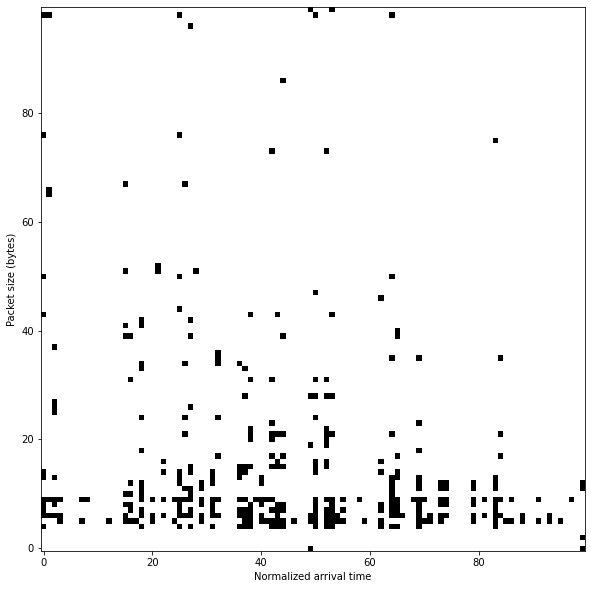

In [152]:
fig, ax = plt.subplots(figsize=(10, 10))
h = flowpic(chunks[0], bins=100, draw=True, draw_binary=True)

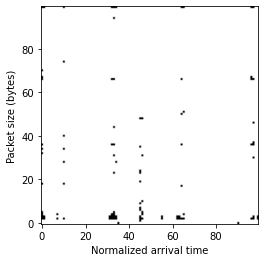

In [138]:
flowpic(chunk(unbinned)[1], 100, True, True);


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



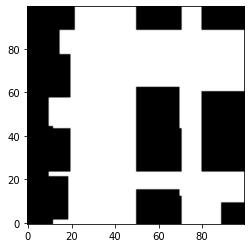

In [139]:
options = {'cmap': 'Greys', 'origin': 'lower', 'vmin': 0, 'vmax': 1}

size = 20
h1 = tf.constant(h)
h2 = tf.reshape(h1, (1, *h1.shape, 1))
maxpool = keras.layers.MaxPool2D(pool_size=(size,size), strides=(1,1), padding='same')
pooled = maxpool(h2)
plt.imshow(pooled.numpy().reshape(*h1.shape).T > 0, **options)